In [1]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/pokemon.zip

Archive:  /content/drive/MyDrive/pokemon.zip
  inflating: pokemon/pokemon/1.png   
  inflating: pokemon/pokemon/10.png  
  inflating: pokemon/pokemon/100.png  
  inflating: pokemon/pokemon/101.png  
  inflating: pokemon/pokemon/102.png  
  inflating: pokemon/pokemon/103.png  
  inflating: pokemon/pokemon/104.png  
  inflating: pokemon/pokemon/105.png  
  inflating: pokemon/pokemon/106.png  
  inflating: pokemon/pokemon/107.png  
  inflating: pokemon/pokemon/108.png  
  inflating: pokemon/pokemon/109.png  
  inflating: pokemon/pokemon/11.png  
  inflating: pokemon/pokemon/110.png  
  inflating: pokemon/pokemon/111.png  
  inflating: pokemon/pokemon/112.png  
  inflating: pokemon/pokemon/113.png  
  inflating: pokemon/pokemon/114.png  
  inflating: pokemon/pokemon/115-mega.png  
  inflating: pokemon/pokemon/115.png  
  inflating: pokemon/pokemon/116.png  
  inflating: pokemon/pokemon/117.png  
  inflating: pokemon/pokemon/118.png  
  inflating: pokemon/pokemon/119.png  
  inflating: poke

In [3]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torchvision.utils import save_image,make_grid

In [4]:
from torchvision.datasets import VisionDataset
from PIL import Image
import os

class CustomDataset(VisionDataset):
    def __init__(self, root, transform=None):
        super(CustomDataset, self).__init__(root, transform=transform)
        self.root = root
        self.transform = transform
        self.images = []  # List to store image paths

        # Load image paths
        for pokemon_folder in os.listdir(root):
            pokemon_path = os.path.join(root, pokemon_folder)
            if os.path.isdir(pokemon_path):
                for image_file in os.listdir(pokemon_path):
                    if image_file.endswith('.png'):  # Assuming images are PNG format
                        image_path = os.path.join(pokemon_path, image_file)
                        self.images.append(image_path)

    def __getitem__(self, index):
        image_path = self.images[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image

    def __len__(self):
        return len(self.images)


In [5]:
import torchvision.transforms as transforms

transform = transforms.Compose([  # Resize images to match MNIST dimensions
    transforms.ToTensor()         # Convert PIL image to PyTorch tensor
])


In [6]:

cuda=True
DEVICE=torch.device("cuda" if cuda else "cpu")

batch_size = 32
x_dim = 256 * 256
hidden_dim = 400
latent_dim = 200
lr = 2e-4
epochs = 500

In [7]:
from torch.utils.data import DataLoader
kwargs = {'num_workers': 1, 'pin_memory': True}
custom_dataset = CustomDataset(root='/content/pokemon', transform=transform)

custom_loader = DataLoader(dataset=custom_dataset, batch_size=batch_size, shuffle=True, **kwargs)


In [8]:
len(custom_dataset)

819

In [9]:
custom_dataset

Dataset CustomDataset
    Number of datapoints: 819
    Root location: /content/pokemon
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [10]:
class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance
                                                       #             (i.e., parateters of simple tractable normal distribution "q"

        return mean, log_var

In [11]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))

        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

In [12]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon
        z = mean + var*epsilon                          # reparameterization trick
        return z


    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)

        return x_hat, mean, log_var

In [13]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [14]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

In [15]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, x in enumerate(custom_loader):
        x = x.view(-1, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  120591.23609375
	Epoch 2 complete! 	Average Loss:  95310.7609375
	Epoch 3 complete! 	Average Loss:  92385.9315625
	Epoch 4 complete! 	Average Loss:  90540.97171875
	Epoch 5 complete! 	Average Loss:  89201.5846875
	Epoch 6 complete! 	Average Loss:  87548.043125
	Epoch 7 complete! 	Average Loss:  85691.09875
	Epoch 8 complete! 	Average Loss:  83715.68578125
	Epoch 9 complete! 	Average Loss:  82671.98671875
	Epoch 10 complete! 	Average Loss:  81733.653125
	Epoch 11 complete! 	Average Loss:  80821.235
	Epoch 12 complete! 	Average Loss:  79593.47265625
	Epoch 13 complete! 	Average Loss:  78374.14921875
	Epoch 14 complete! 	Average Loss:  77511.22625
	Epoch 15 complete! 	Average Loss:  77083.5228125
	Epoch 16 complete! 	Average Loss:  76602.5796875
	Epoch 17 complete! 	Average Loss:  76230.4153125
	Epoch 18 complete! 	Average Loss:  75816.0175
	Epoch 19 complete! 	Average Loss:  75273.72828125
	Epoch 20 complete! 	Average Loss:  74873.

In [16]:
import matplotlib.pyplot as plt

In [17]:
model.eval()

with torch.no_grad():
    for batch_idx, x in enumerate(tqdm(custom_loader)):
        x = x.view(-1, x_dim)
        x = x.to(DEVICE)

        x_hat, _, _ = model(x)


        break

  0%|          | 0/26 [00:00<?, ?it/s]


In [18]:
print(model(x))

(tensor([[7.0937e-08, 5.1950e-09, 5.3965e-09,  ..., 6.7638e-08, 2.6688e-08,
         3.3792e-08],
        [9.9079e-07, 5.7811e-08, 6.6665e-08,  ..., 3.9071e-07, 1.7413e-07,
         1.8737e-07],
        [2.3910e-07, 1.1246e-08, 1.1897e-08,  ..., 8.7483e-08, 3.3691e-08,
         3.9938e-08],
        ...,
        [5.1411e-21, 1.3330e-20, 1.4912e-23,  ..., 6.5394e-25, 9.6760e-24,
         4.0735e-24],
        [2.5388e-20, 5.0052e-20, 5.1331e-23,  ..., 3.9504e-24, 2.6580e-23,
         2.2188e-23],
        [4.9294e-22, 1.2293e-21, 6.9355e-25,  ..., 3.4969e-26, 5.0783e-25,
         3.4458e-25]], device='cuda:0', grad_fn=<SigmoidBackward0>), tensor([[ 0.2613, -0.7046, -0.9700,  ..., -1.4004, -0.8691,  1.2905],
        [-0.1526, -0.2494, -0.8309,  ..., -1.4069, -0.6531,  0.8898],
        [-0.0592, -0.3391, -0.8946,  ..., -1.5094, -0.6805,  0.9381],
        ...,
        [-0.2844,  0.2220, -2.0946,  ...,  1.3474,  0.8030,  2.0581],
        [-0.6266,  0.5042, -2.0210,  ...,  1.0522,  0.7207,  2.2

In [21]:
def show_image(x, idx):
    fig = plt.figure()
    plt.imshow(x[idx].view(256, 256).cpu().numpy())


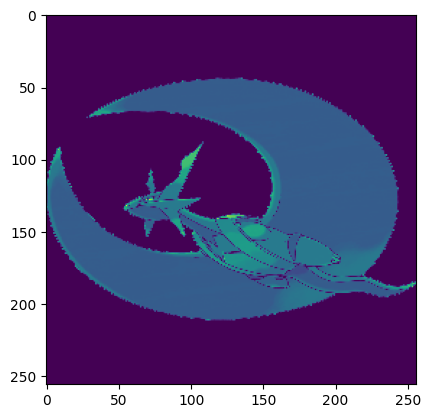

In [22]:
show_image(x,idx=4)

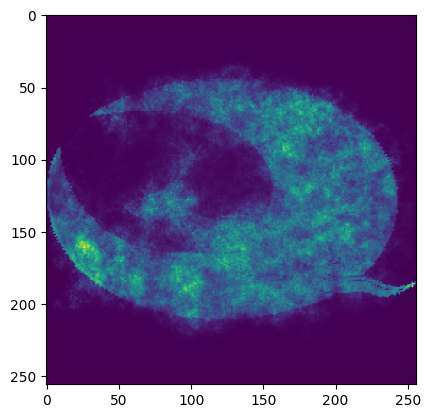

In [23]:

show_image(x_hat, idx=4)

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def plot_grid_images(images, ncols=6):
    nrows = (len(images) + ncols - 1) // ncols  # Calculate the number of rows needed
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))  # Create subplots

    for i, ax in enumerate(axes.flatten()):
        if i < len(images):
            ax.imshow(images[i].view(256, 256).cpu().numpy(), cmap='gray')
        ax.axis('off')  # Turn off axis

    # Hide any remaining empty subplots
    for j in range(len(images), nrows * ncols):
        axes.flatten()[j].axis('off')

    plt.tight_layout()  # Adjust layout
    plt.show()


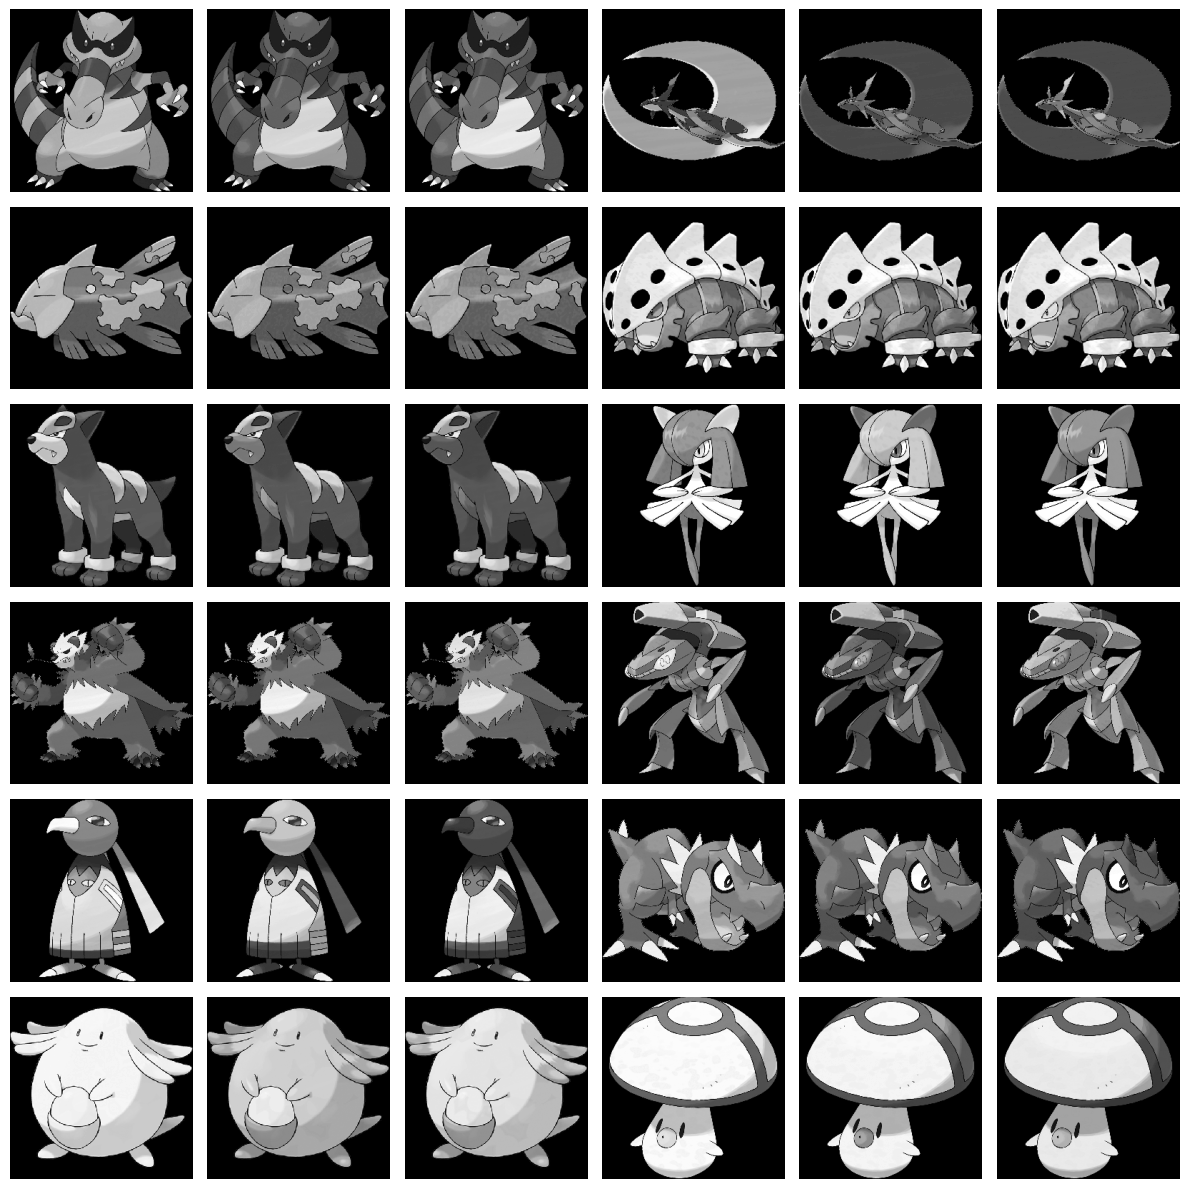

In [27]:
plot_grid_images(x[:36], ncols=6)

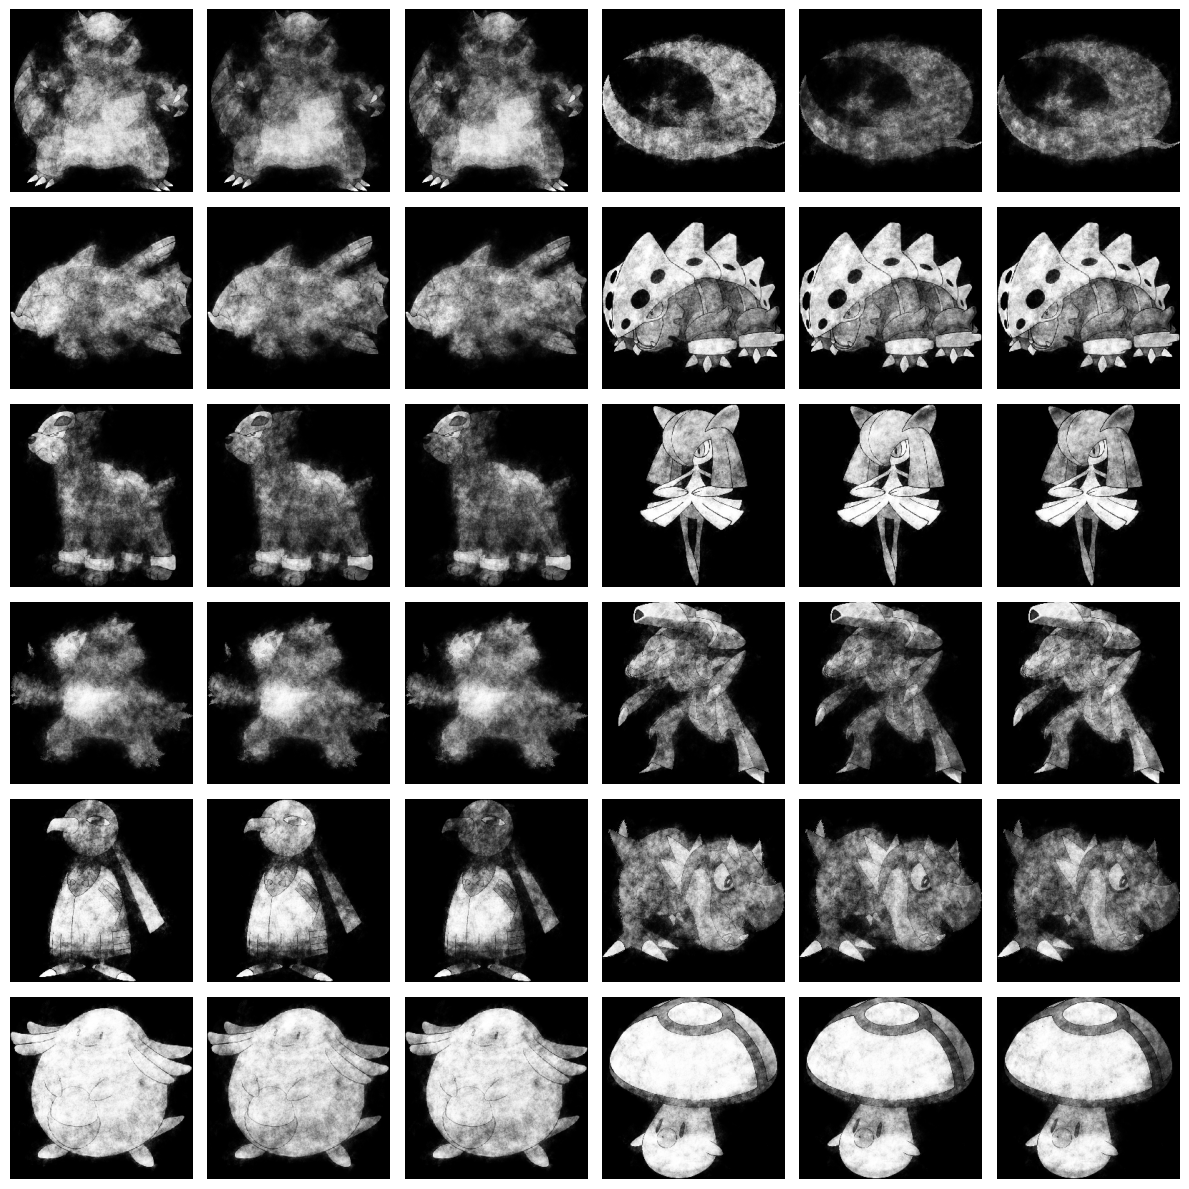

In [28]:
plot_grid_images(x_hat[:36], ncols=6)


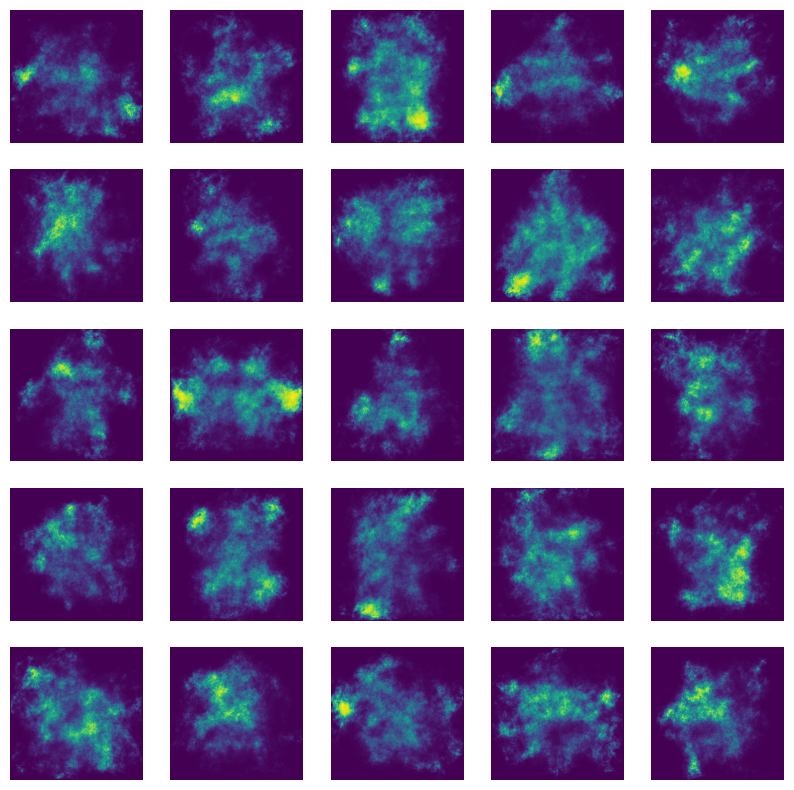

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# sample from normal distr->give the sample to decoder
def generate_images(model, num_images=25, latent_dim=latent_dim):
    with torch.no_grad():
        #we sample from a gaussian distribution since the leaned latent space is also multivariate gaussiam
        z = torch.randn(num_images, latent_dim).to(DEVICE)
        #decode
        generated_images = model.Decoder(z)
        generated_images = generated_images.view(-1, 256, 256)
        return generated_images.cpu().numpy()

#generate
generated_images = generate_images(model, num_images=25)

# Plot the generated images in a grid
rows = 5
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i in range(rows):
    for j in range(cols):
        axes[i,j].imshow(generated_images[i*rows + j])
        axes[i,j].axis('off')

plt.show()
